# Illustration of the Problem
![](MountainCar.png)

In [9]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import torch
from torch import nn
from collections import deque
import random

#Test out environment and grab state/action space parameters
env = gym.make('MountainCar-v0')
n_actions = env.action_space.n
shape_obs = env.observation_space.shape
env.close()
#Action must be 0 (left), 1 (nothing), or 2 (right)

#Define initial/default parameters
class iparams: #initial parameters
    def __init__(self):
        #default hyperparameters
        self.buffersize = int(1E6)
        self.batchsize = 128
        self.shape_obs = shape_obs
        self.n_actions = n_actions
        self.nH = [120,120,120]
        self.nA = n_actions
        self.nS = shape_obs[0]

params = iparams()

#My favorite print function
def printo(string):
    print(string,eval(string))

#Plotting mountain car trajectory from observations
def plot_trajectory(lst_obs):
    obs_vec = np.array(lst_obs)
    plt.figure(figsize=(10,3))
    time_addition = np.array(range(np.shape(obs_vec)[0]))/500
    default = np.array(range(1000))/1000*1.8-1.2
    plt.plot(obs_vec[:,0],np.sin(3*obs_vec[:,0])+time_addition,'.',
        label='Cart Trajectory')
    plt.plot(default,np.sin(3*default),label='Ground')
    plt.xlim([-1.2,0.6])
    plt.ylim([-1,1.1])
    plt.xlabel('Horizontal Position')
    plt.ylabel('Vertical with Time Addition')
    plt.legend()
    plt.show()

#Data buffer for storing data
class bufferobject:
    def __init__(self,params):
        self.buffersize=params.buffersize
        self.defaultbatch = params.batchsize
        self.index = 0
        #obs_dims = (self.buffersize,) + shape_obs
        #self.state = np.zeros(size=obs_dims)
        #self.actions = np
        #self.state = deque(maxlen=self.buffersize)
        #self.action = deque(maxlen=self.buffersize)
        #self.reward = deque(maxlen=self.buffersize)
        #self.nextstate = deque(maxlen=self.buffersize)
        self.experience = deque(maxlen=self.buffersize)

    def add(self,s,a,r,s_,d):
        #self.state.append(s)
        #self.action.append(a)
        #self.reward.append(r)
        #self.nextstate.append(s_)
        #self.index +=1
        self.experience.append([s,a,r,s_,d])
        self.index +=1

    
    def sample(self,batch = 32):
        #vec = range(min(self.index,self.buffersize))
        #ind = np.random.choice(a=vec,b=batchsize)
        #self.experience.sample
        K = min(self.index,self.buffersize,batch)
        samples = random.sample(self.experience, K)
        
        s,a,r,s_,d = zip(*samples)
        s = torch.tensor( s, dtype=torch.float)
        a = torch.tensor( a, dtype=torch.long).view(K, -1)
        r = torch.tensor( r, dtype=torch.float).view(K, -1)
        s_ = torch.tensor( s_, dtype=torch.float)
        d = torch.tensor( d, dtype=torch.float)
        return s,a,r,s_,d


In [8]:
env.observation_space.shape[0]

2

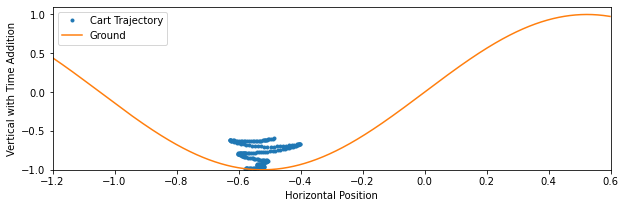

In [3]:
#Test Episode for Environment/Buffer
env = gym.make('MountainCar-v0')
s = env.reset()
buffer = bufferobject(params)
#printo('env.action_space')
#printo('env.observation_space')
#Action must be 0 (left), 1 (nothing), or 2 (right)
#observation, reward, done, _  = env.step(2) 
#printo('observation, reward, done')

lst_obs = []
d=False
while d==False:

    a = np.random.choice([0,1,2])
    s_, r, d, _ = env.step(a)
    buffer.add(s,a,r,s_,d)
    lst_obs.append(s)
    s =  s_
    _,actions,_,_,_ = buffer.sample(batch=5)
    #printo('actions')
plot_trajectory(lst_obs)

env.close()

In [ ]:
#Define Q network
class Qnet(torch.nn.module):
    def __init__(self,params):
        super(Qnet, self).__init__()
        self.nS = params.nS
        self.nH = params.nH
        self.nA = params.nA
        self.layers = nn.Modulelist([])
        
        self.layers.append(nn.Linear(self.nS,self.nH[0]))
        for ind in range(len(self.nH)):
            self.layers.append(nn.Linear)
        self.layers.append(nn.Linear(self.nH[-1],self.nA))


In [74]:
env = gym.make('MountainCar-v0')
actionspace = env.action_space
observationspace = env.observation_space
env.close()

printo('actionspace')
printo('observationspace')
printo('env.observation_space.shape')
printo('env.action_space.n')
dims = env.observation_space.shape
dims = (4,) + dims
printo('dims')
a = np.zeros(shape = (dims))
print(a)


testdeque = deque(maxlen=5)
b = np.array([[3,4],[6,7]])
c = np.array([1,2])
testdeque.append(b)
testdeque.append(c)
print(testdeque)

#d = np.random.choice(np.array(range(10)))
d = np.random.choice(range(10))
printo('d')

printo('testdeque(0:1)')

actionspace Discrete(3)
observationspace Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
env.observation_space.shape (2,)
env.action_space.n 3
dims (4, 2)
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
deque([array([[3, 4],
       [6, 7]]), array([1, 2])], maxlen=5)
d 4


SyntaxError: invalid syntax (<string>, line 1)

SyntaxError: invalid syntax (4267963725.py, line 1)